# Homework: Galaxy Image Classification

**Course:** Deep Learning for Computer Vision

**Objective:** Train a deep learning model to classify galaxy images from the Galaxy10 DECals dataset into one of 10 categories.

**Dataset:** Galaxy10 DECals
* **Source:** [Hugging Face Datasets](https://huggingface.co/datasets/matthieulel/galaxy10_decals)
* **Description:** Contains 17,736 color galaxy images (256x256 pixels) divided into 10 classes. Images originate from DESI Legacy Imaging Surveys, with labels from Galaxy Zoo.
* **Classes:**
    * 0: Disturbed Galaxies
    * 1: Merging Galaxies
    * 2: Round Smooth Galaxies
    * 3: In-between Round Smooth Galaxies
    * 4: Cigar Shaped Smooth Galaxies
    * 5: Barred Spiral Galaxies
    * 6: Unbarred Tight Spiral Galaxies
    * 7: Unbarred Loose Spiral Galaxies
    * 8: Edge-on Galaxies without Bulge
    * 9: Edge-on Galaxies with Bulge

**Tasks:**
1.  Load and explore the dataset.
2.  Preprocess the images.
3.  Define and train a model.
4.  Evaluate the model's performance using standard classification metrics on the test set.

Homework is succesfully completed if you get >0.9 Accuracy on the Test set.

# Prerequisites

In [1]:
#!pip install datasets scikit-learn matplotlib numpy -q >> None

import datasets
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay

/home/amorozov/.conda/envs/cv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Cell 4: Visualize one example from each class
def show_class_examples(dataset, class_names_map, samples_per_row=5, num_rows=2):
    """Displays one sample image for each class."""
    if not dataset:
        print("Dataset not loaded. Cannot visualize.")
        return

    num_classes_to_show = len(class_names_map)
    if num_classes_to_show > samples_per_row * num_rows:
        print(f"Warning: Not enough space to show all {num_classes_to_show} classes.")
        num_classes_to_show = samples_per_row * num_rows

    fig, axes = plt.subplots(num_rows, samples_per_row, figsize=(15, 6)) # Adjusted figsize
    axes = axes.ravel() # Flatten the axes array

    split_name = 'train' if 'train' in dataset else list(dataset.keys())[0]
    data_split = dataset[split_name]

    images_shown = 0
    processed_labels = set()

    for i in range(len(data_split)):
        if images_shown >= num_classes_to_show:
            break # Stop once we have shown one for each target class

        example = data_split[i]
        label = example['label']

        if label not in processed_labels and label < num_classes_to_show:
            img = example['image']
            ax_idx = label # Use label directly as index into the flattened axes
            axes[ax_idx].imshow(img)
            axes[ax_idx].set_title(f"Class {label}: {class_names_map[label]}", fontsize=9)
            axes[ax_idx].axis('off')
            processed_labels.add(label)
            images_shown += 1

    # Hide any unused subplots
    for i in range(images_shown, len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

In [3]:
def evaluate_predictions(predicted_labels, true_labels, class_names_list):
    """
    Calculates and prints classification metrics from predicted labels and true labels.

    Args:
        predicted_labels (list or np.array): The predicted class indices for the test set.
        true_labels (list or np.array): The ground truth class indices for the test set.
        class_names_list (list): A list of strings containing the names of the classes.
    """
    if len(predicted_labels) != len(true_labels):
        print(f"Error: Number of predictions ({len(predicted_labels)}) does not match number of true labels ({len(true_labels)}).")
        return None # Indicate failure

    print(f"Evaluating {len(predicted_labels)} predictions against true labels...")

    # Ensure inputs are numpy arrays for scikit-learn
    predicted_labels = np.array(predicted_labels)
    true_labels = np.array(true_labels)

    # Calculate metrics using scikit-learn
    accuracy = accuracy_score(true_labels, predicted_labels)
    # Calculate precision, recall, f1 per class and average (weighted)
    # Use zero_division=0 to handle cases where a class might not be predicted or present in labels
    precision, recall, f1, _ = precision_recall_fscore_support(
        true_labels, predicted_labels, average='weighted', zero_division=0
    )
    # Get per-class metrics as well
    per_class_precision, per_class_recall, per_class_f1, per_class_support = precision_recall_fscore_support(
        true_labels, predicted_labels, average=None, zero_division=0, labels=range(len(class_names_list))
    )

    # Generate Confusion Matrix
    cm = confusion_matrix(true_labels, predicted_labels, labels=range(len(class_names_list)))

    # Print Metrics
    print(f"\n--- Evaluation Metrics ---")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Weighted Precision: {precision:.4f}")
    print(f"Weighted Recall: {recall:.4f}")
    print(f"Weighted F1-Score: {f1:.4f}")
    print("-" * 25)
    print("Per-Class Metrics:")
    print(f"{'Class':<30} | {'Precision':<10} | {'Recall':<10} | {'F1-Score':<10} | {'Support':<10}")
    print("-" * 80)
    for i, name in enumerate(class_names_list):
       # Handle cases where support might be 0 for a class in true labels if dataset is small/filtered
        support = per_class_support[i] if i < len(per_class_support) else 0
        prec = per_class_precision[i] if i < len(per_class_precision) else 0
        rec = per_class_recall[i] if i < len(per_class_recall) else 0
        f1s = per_class_f1[i] if i < len(per_class_f1) else 0
        print(f"{f'{i}: {name}':<30} | {prec:<10.4f} | {rec:<10.4f} | {f1s:<10.4f} | {support:<10}")
    print("-" * 80)

    # Plot Confusion Matrix
    print("\nPlotting Confusion Matrix...")
    fig, ax = plt.subplots(figsize=(10, 10))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names_list)
    disp.plot(cmap=plt.cm.Blues, ax=ax, xticks_rotation='vertical')
    plt.title('Confusion Matrix')
    plt.tight_layout() # Adjust layout to prevent overlap
    plt.show()

    metrics = {
        'accuracy': accuracy,
        'precision_weighted': precision,
        'recall_weighted': recall,
        'f1_weighted': f1,
        'confusion_matrix': cm,
        'per_class_metrics': {
            'precision': per_class_precision,
            'recall': per_class_recall,
            'f1': per_class_f1,
            'support': per_class_support
        }
    }
    return metrics

# Data

In [4]:
dataset_name = "matthieulel/galaxy10_decals"
galaxy_dataset = datasets.load_dataset(dataset_name)

# Define class names based on the dataset card
class_names = [
    "Disturbed", "Merging", "Round Smooth", "In-between Round Smooth",
    "Cigar Shaped Smooth", "Barred Spiral", "Unbarred Tight Spiral",
    "Unbarred Loose Spiral", "Edge-on without Bulge", "Edge-on with Bulge"
]

# Create a dictionary for easy lookup
label2name = {i: name for i, name in enumerate(class_names)}
name2label = {name: i for i, name in enumerate(class_names)}

num_classes = len(class_names)
print(f"\nNumber of classes: {num_classes}")
print("Class names:", class_names)


Number of classes: 10
Class names: ['Disturbed', 'Merging', 'Round Smooth', 'In-between Round Smooth', 'Cigar Shaped Smooth', 'Barred Spiral', 'Unbarred Tight Spiral', 'Unbarred Loose Spiral', 'Edge-on without Bulge', 'Edge-on with Bulge']


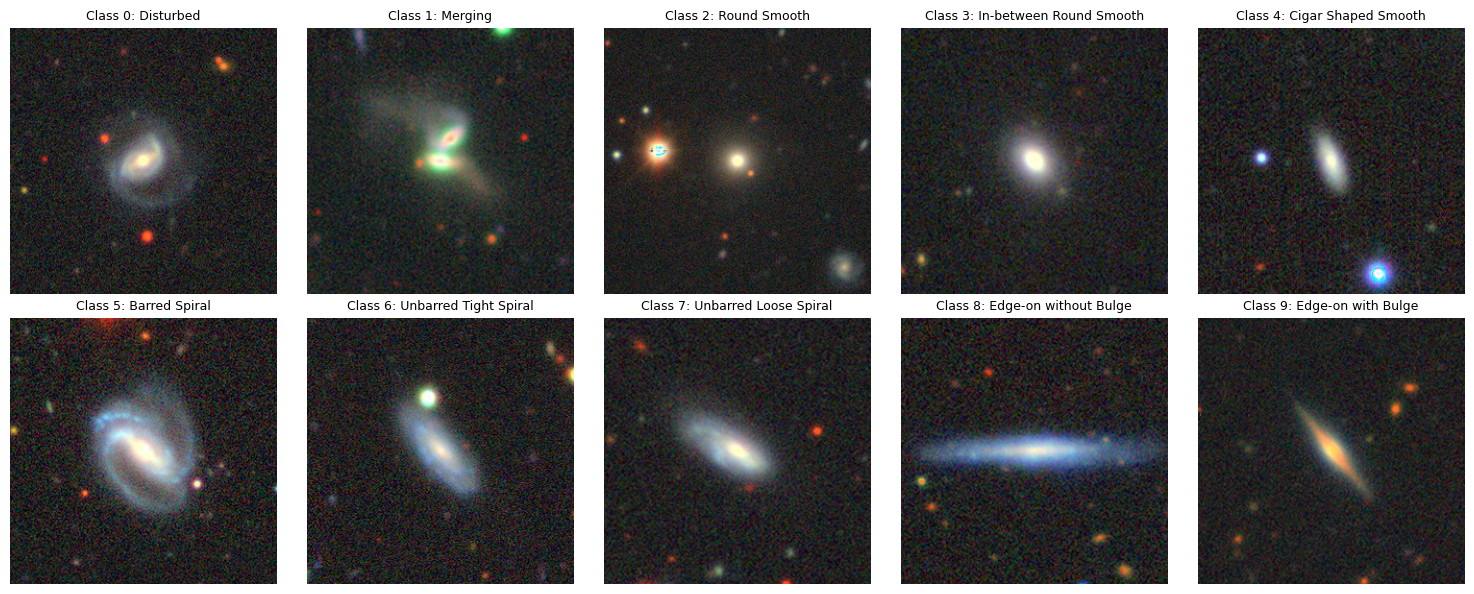

In [5]:
show_class_examples(galaxy_dataset, label2name, samples_per_row=5, num_rows=2)

# Your training code here

In [6]:
import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from wavemix.classification import WaveMix

In [7]:
from sklearn.model_selection import train_test_split


# Split original training set into train/validation
train_val_split = galaxy_dataset['train'].train_test_split(test_size=0.2, seed=42)

# Update dataset dict
galaxy_dataset = datasets.DatasetDict({
    'train': train_val_split['train'],
    'validation': train_val_split['test'],
    'test': galaxy_dataset['test']
})

class GalaxyDataset(Dataset):
    def __init__(self, hf_dataset, transform=None):
        self.dataset = hf_dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        image = item['image'].convert('RGB')
        label = item['label']
        
        if self.transform:
            image = self.transform(image)
            
        return image, label

# Updated transforms that authors of WaveMix had used
train_transform = transforms.Compose([
    transforms.TrivialAugmentWide(),
    transforms.ToTensor(),
    ])

val_test_transform = transforms.Compose([
    transforms.TrivialAugmentWide(),
    transforms.ToTensor(),
    ])

train_dataset = GalaxyDataset(galaxy_dataset['train'], transform=train_transform)
val_dataset = GalaxyDataset(galaxy_dataset['validation'], transform=val_test_transform)
test_dataset = GalaxyDataset(galaxy_dataset['test'], transform=transforms.ToTensor())

In [8]:
labels = galaxy_dataset['train']['label']
class_counts = np.bincount(labels)
class_weights = len(labels) / (len(class_counts) * (class_counts + 1e-6))
class_weights = torch.tensor(class_weights, dtype=torch.float32)

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = WaveMix(
    num_classes = 10,
    depth = 16,
    mult = 2,
    ff_channel = 192,
    final_dim = 192,
    dropout = 0.5,
    level = 3,
    initial_conv = 'pachify',
    patch_size = 4
    ).to(device)

In [10]:
# Hyperparameters
batch_size = 64
lr = 3e-4
weight_decay = 1e-4
num_epochs = 50

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = optim.AdamW(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01, amsgrad=False)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=3)

In [11]:
from tqdm.auto import tqdm
import time
from collections import defaultdict

best_val_acc = 0.0
metrics = defaultdict(list)

epoch_bar = tqdm(range(num_epochs), desc="Training Progress", unit='epoch')

for epoch in epoch_bar:
    epoch_start = time.time()
    model.train()
    
    train_metrics = {'loss': 0.0, 'correct': 0, 'total': 0}
    
    for step, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        if (step + 1) % 2 == 0:
            optimizer.step()
            optimizer.zero_grad()
        
        train_metrics['loss'] += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        train_metrics['correct'] += (predicted == labels).sum().item()
        train_metrics['total'] += labels.size(0)
    
    # Calculate epoch training metrics
    train_loss = train_metrics['loss'] / train_metrics['total']
    train_acc = train_metrics['correct'] / train_metrics['total']
    metrics['train_loss'].append(train_loss)
    metrics['train_acc'].append(train_acc)

    # Validation phase
    model.eval()
    val_metrics = {'loss': 0.0, 'correct': 0, 'total': 0}
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            val_metrics['loss'] += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            val_metrics['correct'] += (predicted == labels).sum().item()
            val_metrics['total'] += labels.size(0)
    
    # Calculate epoch validation metrics
    val_loss = val_metrics['loss'] / val_metrics['total']
    val_acc = val_metrics['correct'] / val_metrics['total']
    metrics['val_loss'].append(val_loss)
    metrics['val_acc'].append(val_acc)
    
    scheduler.step(val_acc)
    
    epoch_time = time.time() - epoch_start
    epoch_bar.set_postfix({
        'train_loss': f"{train_loss:.4f}",
        'train_acc': f"{train_acc:.4f}",
        'val_loss': f"{val_loss:.4f}",
        'val_acc': f"{val_acc:.4f}",
        'lr': f"{optimizer.param_groups[0]['lr']:.2e}",
        'time': f"{epoch_time:.1f}s"
    })
    
    tqdm.write(f"\nEpoch {epoch+1}/{num_epochs} Summary:")
    tqdm.write(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    tqdm.write(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")
    tqdm.write(f"Learning Rate: {optimizer.param_groups[0]['lr']:.2e}")
    tqdm.write(f"Time: {epoch_time:.1f}s\n")
    
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'wavemix_try2.pth')
        tqdm.write(f"New best validation accuracy: {best_val_acc:.4f}")

tqdm.write("\nTraining Complete!")
tqdm.write(f"Best Validation Accuracy: {best_val_acc:.4f}")

Training Progress:   0%|          | 0/50 [04:04<?, ?epoch/s, train_loss=2.4679, train_acc=0.1571, val_loss=2.8369, val_acc=0.1594, lr=1.00e-03, time=244.1s]


Epoch 1/50 Summary:
Train Loss: 2.4679 | Train Acc: 0.1571
Val Loss: 2.8369 | Val Acc: 0.1594
Learning Rate: 1.00e-03
Time: 244.1s



Training Progress:   2%|▏         | 1/50 [04:04<3:19:31, 244.32s/epoch, train_loss=2.4679, train_acc=0.1571, val_loss=2.8369, val_acc=0.1594, lr=1.00e-03, time=244.1s]

New best validation accuracy: 0.1594


Training Progress:   4%|▍         | 2/50 [08:06<3:14:14, 242.80s/epoch, train_loss=2.2201, train_acc=0.1944, val_loss=2.2930, val_acc=0.1159, lr=1.00e-03, time=241.7s]


Epoch 2/50 Summary:
Train Loss: 2.2201 | Train Acc: 0.1944
Val Loss: 2.2930 | Val Acc: 0.1159
Learning Rate: 1.00e-03
Time: 241.7s



Training Progress:   4%|▍         | 2/50 [12:07<3:14:14, 242.80s/epoch, train_loss=2.1354, train_acc=0.2030, val_loss=2.2267, val_acc=0.1992, lr=1.00e-03, time=241.6s]


Epoch 3/50 Summary:
Train Loss: 2.1354 | Train Acc: 0.2030
Val Loss: 2.2267 | Val Acc: 0.1992
Learning Rate: 1.00e-03
Time: 241.6s



Training Progress:   6%|▌         | 3/50 [12:07<3:09:52, 242.38s/epoch, train_loss=2.1354, train_acc=0.2030, val_loss=2.2267, val_acc=0.1992, lr=1.00e-03, time=241.6s]

New best validation accuracy: 0.1992


Training Progress:   6%|▌         | 3/50 [16:09<3:09:52, 242.38s/epoch, train_loss=2.0907, train_acc=0.2334, val_loss=2.2010, val_acc=0.2039, lr=1.00e-03, time=241.7s]


Epoch 4/50 Summary:
Train Loss: 2.0907 | Train Acc: 0.2334
Val Loss: 2.2010 | Val Acc: 0.2039
Learning Rate: 1.00e-03
Time: 241.7s



Training Progress:   8%|▊         | 4/50 [16:09<3:05:43, 242.25s/epoch, train_loss=2.0907, train_acc=0.2334, val_loss=2.2010, val_acc=0.2039, lr=1.00e-03, time=241.7s]

New best validation accuracy: 0.2039


Training Progress:   8%|▊         | 4/50 [20:11<3:05:43, 242.25s/epoch, train_loss=2.0215, train_acc=0.2638, val_loss=2.0397, val_acc=0.2487, lr=1.00e-03, time=241.9s]


Epoch 5/50 Summary:
Train Loss: 2.0215 | Train Acc: 0.2638
Val Loss: 2.0397 | Val Acc: 0.2487
Learning Rate: 1.00e-03
Time: 241.9s



Training Progress:  10%|█         | 5/50 [20:12<3:01:39, 242.21s/epoch, train_loss=2.0215, train_acc=0.2638, val_loss=2.0397, val_acc=0.2487, lr=1.00e-03, time=241.9s]

New best validation accuracy: 0.2487


Training Progress:  10%|█         | 5/50 [24:14<3:01:39, 242.21s/epoch, train_loss=1.9521, train_acc=0.2753, val_loss=2.0372, val_acc=0.2750, lr=1.00e-03, time=241.9s]


Epoch 6/50 Summary:
Train Loss: 1.9521 | Train Acc: 0.2753
Val Loss: 2.0372 | Val Acc: 0.2750
Learning Rate: 1.00e-03
Time: 241.9s



Training Progress:  12%|█▏        | 6/50 [24:14<2:57:35, 242.17s/epoch, train_loss=1.9521, train_acc=0.2753, val_loss=2.0372, val_acc=0.2750, lr=1.00e-03, time=241.9s]

New best validation accuracy: 0.2750


Training Progress:  14%|█▍        | 7/50 [28:16<2:53:29, 242.09s/epoch, train_loss=1.8883, train_acc=0.3097, val_loss=1.9629, val_acc=0.2224, lr=1.00e-03, time=241.9s]


Epoch 7/50 Summary:
Train Loss: 1.8883 | Train Acc: 0.3097
Val Loss: 1.9629 | Val Acc: 0.2224
Learning Rate: 1.00e-03
Time: 241.9s



Training Progress:  16%|█▌        | 8/50 [32:18<2:49:26, 242.06s/epoch, train_loss=1.8321, train_acc=0.3187, val_loss=2.1083, val_acc=0.2471, lr=1.00e-03, time=242.0s]


Epoch 8/50 Summary:
Train Loss: 1.8321 | Train Acc: 0.3187
Val Loss: 2.1083 | Val Acc: 0.2471
Learning Rate: 1.00e-03
Time: 242.0s



Training Progress:  16%|█▌        | 8/50 [36:20<2:49:26, 242.06s/epoch, train_loss=1.7844, train_acc=0.3454, val_loss=1.8084, val_acc=0.3163, lr=1.00e-03, time=242.1s]


Epoch 9/50 Summary:
Train Loss: 1.7844 | Train Acc: 0.3454
Val Loss: 1.8084 | Val Acc: 0.3163
Learning Rate: 1.00e-03
Time: 242.1s



Training Progress:  18%|█▊        | 9/50 [36:20<2:45:29, 242.18s/epoch, train_loss=1.7844, train_acc=0.3454, val_loss=1.8084, val_acc=0.3163, lr=1.00e-03, time=242.1s]

New best validation accuracy: 0.3163


Training Progress:  18%|█▊        | 9/50 [40:23<2:45:29, 242.18s/epoch, train_loss=1.7244, train_acc=0.3660, val_loss=1.9599, val_acc=0.3332, lr=1.00e-03, time=242.5s]


Epoch 10/50 Summary:
Train Loss: 1.7244 | Train Acc: 0.3660
Val Loss: 1.9599 | Val Acc: 0.3332
Learning Rate: 1.00e-03
Time: 242.5s



Training Progress:  20%|██        | 10/50 [40:23<2:41:34, 242.36s/epoch, train_loss=1.7244, train_acc=0.3660, val_loss=1.9599, val_acc=0.3332, lr=1.00e-03, time=242.5s]

New best validation accuracy: 0.3332


Training Progress:  22%|██▏       | 11/50 [44:27<2:37:49, 242.80s/epoch, train_loss=1.6951, train_acc=0.3732, val_loss=1.8653, val_acc=0.2437, lr=1.00e-03, time=243.8s]


Epoch 11/50 Summary:
Train Loss: 1.6951 | Train Acc: 0.3732
Val Loss: 1.8653 | Val Acc: 0.2437
Learning Rate: 1.00e-03
Time: 243.8s



Training Progress:  24%|██▍       | 12/50 [48:29<2:33:40, 242.65s/epoch, train_loss=1.6395, train_acc=0.3844, val_loss=1.8593, val_acc=0.3194, lr=1.00e-03, time=242.3s]


Epoch 12/50 Summary:
Train Loss: 1.6395 | Train Acc: 0.3844
Val Loss: 1.8593 | Val Acc: 0.3194
Learning Rate: 1.00e-03
Time: 242.3s



Training Progress:  24%|██▍       | 12/50 [52:31<2:33:40, 242.65s/epoch, train_loss=1.6493, train_acc=0.3992, val_loss=1.6593, val_acc=0.3811, lr=1.00e-03, time=242.1s]


Epoch 13/50 Summary:
Train Loss: 1.6493 | Train Acc: 0.3992
Val Loss: 1.6593 | Val Acc: 0.3811
Learning Rate: 1.00e-03
Time: 242.1s



Training Progress:  26%|██▌       | 13/50 [52:31<2:29:35, 242.58s/epoch, train_loss=1.6493, train_acc=0.3992, val_loss=1.6593, val_acc=0.3811, lr=1.00e-03, time=242.1s]

New best validation accuracy: 0.3811


Training Progress:  28%|██▊       | 14/50 [56:33<2:25:27, 242.42s/epoch, train_loss=1.6032, train_acc=0.4112, val_loss=1.7855, val_acc=0.3207, lr=1.00e-03, time=242.0s]


Epoch 14/50 Summary:
Train Loss: 1.6032 | Train Acc: 0.4112
Val Loss: 1.7855 | Val Acc: 0.3207
Learning Rate: 1.00e-03
Time: 242.0s



Training Progress:  28%|██▊       | 14/50 [1:00:35<2:25:27, 242.42s/epoch, train_loss=1.5918, train_acc=0.4198, val_loss=1.7019, val_acc=0.4078, lr=1.00e-03, time=241.9s]


Epoch 15/50 Summary:
Train Loss: 1.5918 | Train Acc: 0.4198
Val Loss: 1.7019 | Val Acc: 0.4078
Learning Rate: 1.00e-03
Time: 241.9s



Training Progress:  30%|███       | 15/50 [1:00:36<2:21:21, 242.34s/epoch, train_loss=1.5918, train_acc=0.4198, val_loss=1.7019, val_acc=0.4078, lr=1.00e-03, time=241.9s]

New best validation accuracy: 0.4078


Training Progress:  30%|███       | 15/50 [1:04:38<2:21:21, 242.34s/epoch, train_loss=1.5821, train_acc=0.4195, val_loss=1.5823, val_acc=0.4294, lr=1.00e-03, time=242.1s]


Epoch 16/50 Summary:
Train Loss: 1.5821 | Train Acc: 0.4195
Val Loss: 1.5823 | Val Acc: 0.4294
Learning Rate: 1.00e-03
Time: 242.1s



Training Progress:  32%|███▏      | 16/50 [1:04:38<2:17:19, 242.33s/epoch, train_loss=1.5821, train_acc=0.4195, val_loss=1.5823, val_acc=0.4294, lr=1.00e-03, time=242.1s]

New best validation accuracy: 0.4294


Training Progress:  34%|███▍      | 17/50 [1:08:40<2:13:13, 242.23s/epoch, train_loss=1.5543, train_acc=0.4348, val_loss=1.5955, val_acc=0.4197, lr=1.00e-03, time=242.0s]


Epoch 17/50 Summary:
Train Loss: 1.5543 | Train Acc: 0.4348
Val Loss: 1.5955 | Val Acc: 0.4197
Learning Rate: 1.00e-03
Time: 242.0s



Training Progress:  34%|███▍      | 17/50 [1:12:42<2:13:13, 242.23s/epoch, train_loss=1.5479, train_acc=0.4361, val_loss=1.6495, val_acc=0.4494, lr=1.00e-03, time=242.2s]


Epoch 18/50 Summary:
Train Loss: 1.5479 | Train Acc: 0.4361
Val Loss: 1.6495 | Val Acc: 0.4494
Learning Rate: 1.00e-03
Time: 242.2s



Training Progress:  36%|███▌      | 18/50 [1:12:42<2:09:12, 242.27s/epoch, train_loss=1.5479, train_acc=0.4361, val_loss=1.6495, val_acc=0.4494, lr=1.00e-03, time=242.2s]

New best validation accuracy: 0.4494


Training Progress:  38%|███▊      | 19/50 [1:16:44<2:05:07, 242.19s/epoch, train_loss=1.5185, train_acc=0.4469, val_loss=1.6317, val_acc=0.4172, lr=1.00e-03, time=242.0s]


Epoch 19/50 Summary:
Train Loss: 1.5185 | Train Acc: 0.4469
Val Loss: 1.6317 | Val Acc: 0.4172
Learning Rate: 1.00e-03
Time: 242.0s



Training Progress:  40%|████      | 20/50 [1:20:46<2:01:03, 242.13s/epoch, train_loss=1.4848, train_acc=0.4520, val_loss=1.6056, val_acc=0.4037, lr=1.00e-03, time=242.0s]


Epoch 20/50 Summary:
Train Loss: 1.4848 | Train Acc: 0.4520
Val Loss: 1.6056 | Val Acc: 0.4037
Learning Rate: 1.00e-03
Time: 242.0s



Training Progress:  42%|████▏     | 21/50 [1:24:48<1:57:02, 242.16s/epoch, train_loss=1.5060, train_acc=0.4530, val_loss=1.4935, val_acc=0.4707, lr=1.00e-03, time=242.0s]


Epoch 21/50 Summary:
Train Loss: 1.5060 | Train Acc: 0.4530
Val Loss: 1.4935 | Val Acc: 0.4707
Learning Rate: 1.00e-03
Time: 242.0s

New best validation accuracy: 0.4707


Training Progress:  44%|████▍     | 22/50 [1:28:50<1:52:58, 242.08s/epoch, train_loss=1.4848, train_acc=0.4584, val_loss=1.6043, val_acc=0.4410, lr=1.00e-03, time=241.9s]


Epoch 22/50 Summary:
Train Loss: 1.4848 | Train Acc: 0.4584
Val Loss: 1.6043 | Val Acc: 0.4410
Learning Rate: 1.00e-03
Time: 241.9s



Training Progress:  46%|████▌     | 23/50 [1:32:52<1:48:55, 242.07s/epoch, train_loss=1.4955, train_acc=0.4568, val_loss=1.5233, val_acc=0.4526, lr=1.00e-03, time=242.0s]


Epoch 23/50 Summary:
Train Loss: 1.4955 | Train Acc: 0.4568
Val Loss: 1.5233 | Val Acc: 0.4526
Learning Rate: 1.00e-03
Time: 242.0s



Training Progress:  48%|████▊     | 24/50 [1:36:54<1:44:53, 242.07s/epoch, train_loss=1.4382, train_acc=0.4736, val_loss=1.4863, val_acc=0.4215, lr=1.00e-03, time=242.1s]


Epoch 24/50 Summary:
Train Loss: 1.4382 | Train Acc: 0.4736
Val Loss: 1.4863 | Val Acc: 0.4215
Learning Rate: 1.00e-03
Time: 242.1s



Training Progress:  50%|█████     | 25/50 [1:40:57<1:40:52, 242.09s/epoch, train_loss=1.4443, train_acc=0.4683, val_loss=1.5338, val_acc=0.4197, lr=1.00e-04, time=242.1s]


Epoch 25/50 Summary:
Train Loss: 1.4443 | Train Acc: 0.4683
Val Loss: 1.5338 | Val Acc: 0.4197
Learning Rate: 1.00e-04
Time: 242.1s



Training Progress:  50%|█████     | 25/50 [1:44:59<1:40:52, 242.09s/epoch, train_loss=1.3566, train_acc=0.5073, val_loss=1.3128, val_acc=0.5355, lr=1.00e-04, time=242.1s]


Epoch 26/50 Summary:
Train Loss: 1.3566 | Train Acc: 0.5073
Val Loss: 1.3128 | Val Acc: 0.5355
Learning Rate: 1.00e-04
Time: 242.1s



Training Progress:  52%|█████▏    | 26/50 [1:44:59<1:36:55, 242.33s/epoch, train_loss=1.3566, train_acc=0.5073, val_loss=1.3128, val_acc=0.5355, lr=1.00e-04, time=242.1s]

New best validation accuracy: 0.5355


Training Progress:  54%|█████▍    | 27/50 [1:49:01<1:32:51, 242.22s/epoch, train_loss=1.3318, train_acc=0.5159, val_loss=1.2826, val_acc=0.5268, lr=1.00e-04, time=242.0s]


Epoch 27/50 Summary:
Train Loss: 1.3318 | Train Acc: 0.5159
Val Loss: 1.2826 | Val Acc: 0.5268
Learning Rate: 1.00e-04
Time: 242.0s



Training Progress:  54%|█████▍    | 27/50 [1:53:03<1:32:51, 242.22s/epoch, train_loss=1.3181, train_acc=0.5239, val_loss=1.2745, val_acc=0.5487, lr=1.00e-04, time=242.0s]


Epoch 28/50 Summary:
Train Loss: 1.3181 | Train Acc: 0.5239
Val Loss: 1.2745 | Val Acc: 0.5487
Learning Rate: 1.00e-04
Time: 242.0s



Training Progress:  56%|█████▌    | 28/50 [1:53:04<1:28:49, 242.27s/epoch, train_loss=1.3181, train_acc=0.5239, val_loss=1.2745, val_acc=0.5487, lr=1.00e-04, time=242.0s]

New best validation accuracy: 0.5487


Training Progress:  58%|█████▊    | 29/50 [1:57:06<1:24:46, 242.21s/epoch, train_loss=1.3025, train_acc=0.5232, val_loss=1.2753, val_acc=0.5368, lr=1.00e-04, time=242.1s]


Epoch 29/50 Summary:
Train Loss: 1.3025 | Train Acc: 0.5232
Val Loss: 1.2753 | Val Acc: 0.5368
Learning Rate: 1.00e-04
Time: 242.1s



Training Progress:  60%|██████    | 30/50 [2:01:08<1:20:43, 242.16s/epoch, train_loss=1.2990, train_acc=0.5279, val_loss=1.2844, val_acc=0.5346, lr=1.00e-04, time=242.0s]


Epoch 30/50 Summary:
Train Loss: 1.2990 | Train Acc: 0.5279
Val Loss: 1.2844 | Val Acc: 0.5346
Learning Rate: 1.00e-04
Time: 242.0s



Training Progress:  62%|██████▏   | 31/50 [2:05:10<1:16:40, 242.12s/epoch, train_loss=1.2825, train_acc=0.5299, val_loss=1.2515, val_acc=0.5449, lr=1.00e-04, time=242.0s]


Epoch 31/50 Summary:
Train Loss: 1.2825 | Train Acc: 0.5299
Val Loss: 1.2515 | Val Acc: 0.5449
Learning Rate: 1.00e-04
Time: 242.0s



Training Progress:  62%|██████▏   | 31/50 [2:09:12<1:16:40, 242.12s/epoch, train_loss=1.2897, train_acc=0.5368, val_loss=1.2484, val_acc=0.5597, lr=1.00e-04, time=242.3s]


Epoch 32/50 Summary:
Train Loss: 1.2897 | Train Acc: 0.5368
Val Loss: 1.2484 | Val Acc: 0.5597
Learning Rate: 1.00e-04
Time: 242.3s



Training Progress:  64%|██████▍   | 32/50 [2:09:13<1:12:41, 242.29s/epoch, train_loss=1.2897, train_acc=0.5368, val_loss=1.2484, val_acc=0.5597, lr=1.00e-04, time=242.3s]

New best validation accuracy: 0.5597


Training Progress:  66%|██████▌   | 33/50 [2:13:15<1:08:38, 242.25s/epoch, train_loss=1.2726, train_acc=0.5397, val_loss=1.2451, val_acc=0.5518, lr=1.00e-04, time=242.1s]


Epoch 33/50 Summary:
Train Loss: 1.2726 | Train Acc: 0.5397
Val Loss: 1.2451 | Val Acc: 0.5518
Learning Rate: 1.00e-04
Time: 242.1s



Training Progress:  68%|██████▊   | 34/50 [2:17:17<1:04:35, 242.21s/epoch, train_loss=1.2632, train_acc=0.5391, val_loss=1.2331, val_acc=0.5547, lr=1.00e-04, time=242.1s]


Epoch 34/50 Summary:
Train Loss: 1.2632 | Train Acc: 0.5391
Val Loss: 1.2331 | Val Acc: 0.5547
Learning Rate: 1.00e-04
Time: 242.1s



Training Progress:  70%|███████   | 35/50 [2:21:19<1:00:32, 242.15s/epoch, train_loss=1.2588, train_acc=0.5402, val_loss=1.2420, val_acc=0.5484, lr=1.00e-04, time=242.0s]


Epoch 35/50 Summary:
Train Loss: 1.2588 | Train Acc: 0.5402
Val Loss: 1.2420 | Val Acc: 0.5484
Learning Rate: 1.00e-04
Time: 242.0s



Training Progress:  72%|███████▏  | 36/50 [2:25:21<56:29, 242.14s/epoch, train_loss=1.2516, train_acc=0.5413, val_loss=1.2256, val_acc=0.5590, lr=1.00e-05, time=242.1s]  


Epoch 36/50 Summary:
Train Loss: 1.2516 | Train Acc: 0.5413
Val Loss: 1.2256 | Val Acc: 0.5590
Learning Rate: 1.00e-05
Time: 242.1s



Training Progress:  72%|███████▏  | 36/50 [2:29:23<56:29, 242.14s/epoch, train_loss=1.2450, train_acc=0.5409, val_loss=1.2044, val_acc=0.5734, lr=1.00e-05, time=242.4s]


Epoch 37/50 Summary:
Train Loss: 1.2450 | Train Acc: 0.5409
Val Loss: 1.2044 | Val Acc: 0.5734
Learning Rate: 1.00e-05
Time: 242.4s



Training Progress:  74%|███████▍  | 37/50 [2:29:24<52:30, 242.31s/epoch, train_loss=1.2450, train_acc=0.5409, val_loss=1.2044, val_acc=0.5734, lr=1.00e-05, time=242.4s]

New best validation accuracy: 0.5734


Training Progress:  76%|███████▌  | 38/50 [2:33:26<48:26, 242.20s/epoch, train_loss=1.2468, train_acc=0.5464, val_loss=1.2062, val_acc=0.5706, lr=1.00e-05, time=241.9s]


Epoch 38/50 Summary:
Train Loss: 1.2468 | Train Acc: 0.5464
Val Loss: 1.2062 | Val Acc: 0.5706
Learning Rate: 1.00e-05
Time: 241.9s



Training Progress:  78%|███████▊  | 39/50 [2:37:28<44:24, 242.20s/epoch, train_loss=1.2463, train_acc=0.5433, val_loss=1.1965, val_acc=0.5653, lr=1.00e-05, time=242.2s]


Epoch 39/50 Summary:
Train Loss: 1.2463 | Train Acc: 0.5433
Val Loss: 1.1965 | Val Acc: 0.5653
Learning Rate: 1.00e-05
Time: 242.2s



Training Progress:  80%|████████  | 40/50 [2:41:30<40:22, 242.26s/epoch, train_loss=1.2530, train_acc=0.5462, val_loss=1.2024, val_acc=0.5684, lr=1.00e-05, time=242.4s]


Epoch 40/50 Summary:
Train Loss: 1.2530 | Train Acc: 0.5462
Val Loss: 1.2024 | Val Acc: 0.5684
Learning Rate: 1.00e-05
Time: 242.4s



Training Progress:  80%|████████  | 40/50 [2:45:32<40:22, 242.26s/epoch, train_loss=1.2343, train_acc=0.5501, val_loss=1.1842, val_acc=0.5772, lr=1.00e-05, time=242.0s]


Epoch 41/50 Summary:
Train Loss: 1.2343 | Train Acc: 0.5501
Val Loss: 1.1842 | Val Acc: 0.5772
Learning Rate: 1.00e-05
Time: 242.0s



Training Progress:  82%|████████▏ | 41/50 [2:45:33<36:20, 242.32s/epoch, train_loss=1.2343, train_acc=0.5501, val_loss=1.1842, val_acc=0.5772, lr=1.00e-05, time=242.0s]

New best validation accuracy: 0.5772


Training Progress:  84%|████████▍ | 42/50 [2:49:35<32:17, 242.25s/epoch, train_loss=1.2354, train_acc=0.5505, val_loss=1.1779, val_acc=0.5709, lr=1.00e-05, time=242.1s]


Epoch 42/50 Summary:
Train Loss: 1.2354 | Train Acc: 0.5505
Val Loss: 1.1779 | Val Acc: 0.5709
Learning Rate: 1.00e-05
Time: 242.1s



Training Progress:  86%|████████▌ | 43/50 [2:53:37<28:16, 242.30s/epoch, train_loss=1.2343, train_acc=0.5502, val_loss=1.2045, val_acc=0.5697, lr=1.00e-05, time=242.4s]


Epoch 43/50 Summary:
Train Loss: 1.2343 | Train Acc: 0.5502
Val Loss: 1.2045 | Val Acc: 0.5697
Learning Rate: 1.00e-05
Time: 242.4s



Training Progress:  88%|████████▊ | 44/50 [2:57:40<24:13, 242.28s/epoch, train_loss=1.2303, train_acc=0.5534, val_loss=1.1892, val_acc=0.5625, lr=1.00e-05, time=242.2s]


Epoch 44/50 Summary:
Train Loss: 1.2303 | Train Acc: 0.5534
Val Loss: 1.1892 | Val Acc: 0.5625
Learning Rate: 1.00e-05
Time: 242.2s



Training Progress:  90%|█████████ | 45/50 [3:01:42<20:11, 242.30s/epoch, train_loss=1.2214, train_acc=0.5559, val_loss=1.2041, val_acc=0.5769, lr=1.00e-06, time=242.3s]


Epoch 45/50 Summary:
Train Loss: 1.2214 | Train Acc: 0.5559
Val Loss: 1.2041 | Val Acc: 0.5769
Learning Rate: 1.00e-06
Time: 242.3s



Training Progress:  92%|█████████▏| 46/50 [3:05:44<16:09, 242.28s/epoch, train_loss=1.2306, train_acc=0.5472, val_loss=1.1908, val_acc=0.5691, lr=1.00e-06, time=242.2s]


Epoch 46/50 Summary:
Train Loss: 1.2306 | Train Acc: 0.5472
Val Loss: 1.1908 | Val Acc: 0.5691
Learning Rate: 1.00e-06
Time: 242.2s



Training Progress:  94%|█████████▍| 47/50 [3:09:46<12:06, 242.24s/epoch, train_loss=1.2329, train_acc=0.5441, val_loss=1.1849, val_acc=0.5606, lr=1.00e-06, time=242.1s]


Epoch 47/50 Summary:
Train Loss: 1.2329 | Train Acc: 0.5441
Val Loss: 1.1849 | Val Acc: 0.5606
Learning Rate: 1.00e-06
Time: 242.1s



Training Progress:  96%|█████████▌| 48/50 [3:13:48<08:04, 242.20s/epoch, train_loss=1.2283, train_acc=0.5498, val_loss=1.1930, val_acc=0.5687, lr=1.00e-06, time=242.1s]


Epoch 48/50 Summary:
Train Loss: 1.2283 | Train Acc: 0.5498
Val Loss: 1.1930 | Val Acc: 0.5687
Learning Rate: 1.00e-06
Time: 242.1s



Training Progress:  98%|█████████▊| 49/50 [3:17:50<04:02, 242.17s/epoch, train_loss=1.2385, train_acc=0.5504, val_loss=1.1956, val_acc=0.5572, lr=1.00e-07, time=242.1s]


Epoch 49/50 Summary:
Train Loss: 1.2385 | Train Acc: 0.5504
Val Loss: 1.1956 | Val Acc: 0.5572
Learning Rate: 1.00e-07
Time: 242.1s



Training Progress: 100%|██████████| 50/50 [3:21:53<00:00, 242.26s/epoch, train_loss=1.2449, train_acc=0.5426, val_loss=1.1905, val_acc=0.5666, lr=1.00e-07, time=242.2s]


Epoch 50/50 Summary:
Train Loss: 1.2449 | Train Acc: 0.5426
Val Loss: 1.1905 | Val Acc: 0.5666
Learning Rate: 1.00e-07
Time: 242.2s


Training Complete!
Best Validation Accuracy: 0.5772


# Evaluation

Evaluating 1774 predictions against true labels...

--- Evaluation Metrics ---
Accuracy: 0.6285
Weighted Precision: 0.6379
Weighted Recall: 0.6285
Weighted F1-Score: 0.6186
-------------------------
Per-Class Metrics:
Class                          | Precision  | Recall     | F1-Score   | Support   
--------------------------------------------------------------------------------
0: Disturbed                   | 0.3721     | 0.2936     | 0.3282     | 109       
1: Merging                     | 0.7222     | 0.4919     | 0.5852     | 185       
2: Round Smooth                | 0.7804     | 0.9240     | 0.8462     | 250       
3: In-between Round Smooth     | 0.6574     | 0.8333     | 0.7350     | 198       
4: Cigar Shaped Smooth         | 0.2941     | 0.8929     | 0.4425     | 28        
5: Barred Spiral               | 0.4825     | 0.5069     | 0.4944     | 217       
6: Unbarred Tight Spiral       | 0.4758     | 0.6034     | 0.5320     | 179       
7: Unbarred Loose Spiral       | 0.60

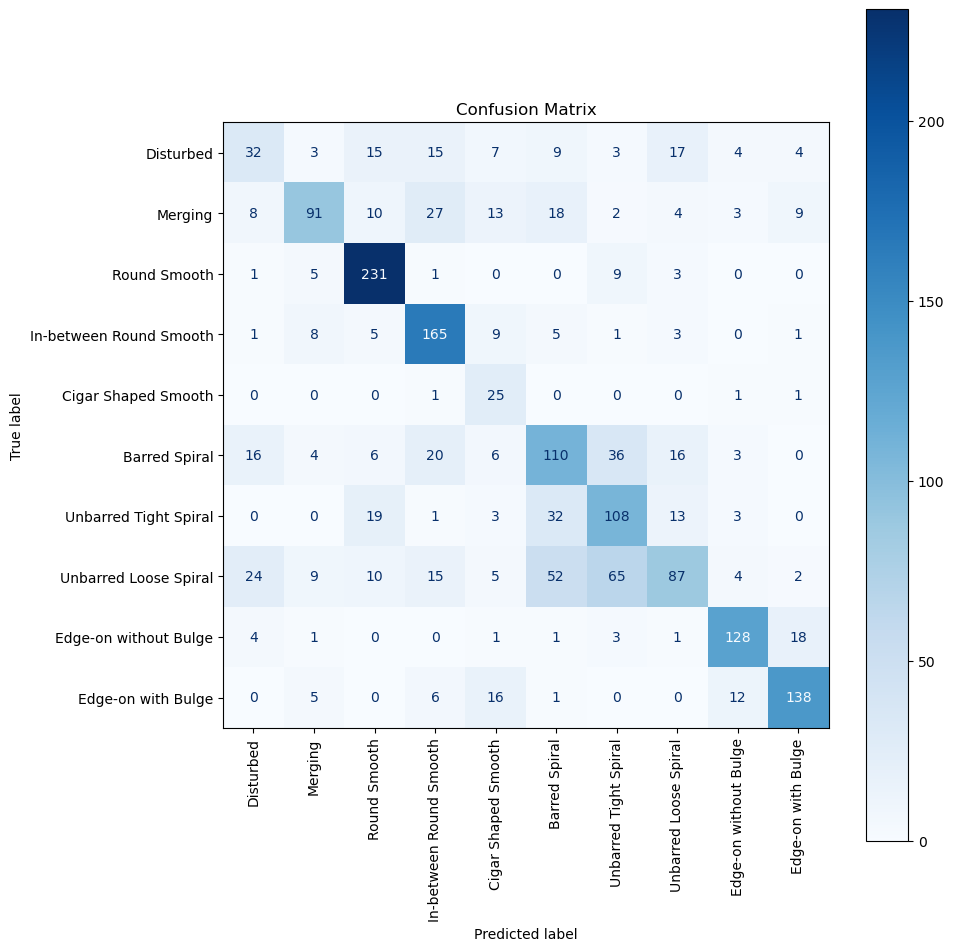

In [11]:
model.load_state_dict(torch.load('/home/amorozov/DL/DL_HW_1_CV/wavemix_try2.pth'))
model.eval()

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    pin_memory=True,
)

preds = []
true_test_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        
        preds.extend(predicted.cpu().numpy())
        true_test_labels.extend(labels.numpy())

preds = np.array(preds)
true_test_labels = np.array(true_test_labels)

assert len(preds) == len(true_test_labels), \
    f"Mismatch: {len(preds)} predictions vs {len(true_test_labels)} labels"

test_metrics = evaluate_predictions(preds, true_test_labels, class_names)

Using device: cuda
Evaluating 1774 predictions against true labels...

--- Evaluation Metrics ---
Accuracy: 0.8286
Weighted Precision: 0.8319
Weighted Recall: 0.8286
Weighted F1-Score: 0.8274
-------------------------
Per-Class Metrics:
Class                          | Precision  | Recall     | F1-Score   | Support   
--------------------------------------------------------------------------------
0: Disturbed                   | 0.4882     | 0.5688     | 0.5254     | 109       
1: Merging                     | 0.8673     | 0.9189     | 0.8924     | 185       
2: Round Smooth                | 0.8397     | 0.9640     | 0.8976     | 250       
3: In-between Round Smooth     | 0.9405     | 0.8788     | 0.9086     | 198       
4: Cigar Shaped Smooth         | 0.7273     | 0.8571     | 0.7869     | 28        
5: Barred Spiral               | 0.8812     | 0.8203     | 0.8496     | 217       
6: Unbarred Tight Spiral       | 0.7292     | 0.7821     | 0.7547     | 179       
7: Unbarred Loose 

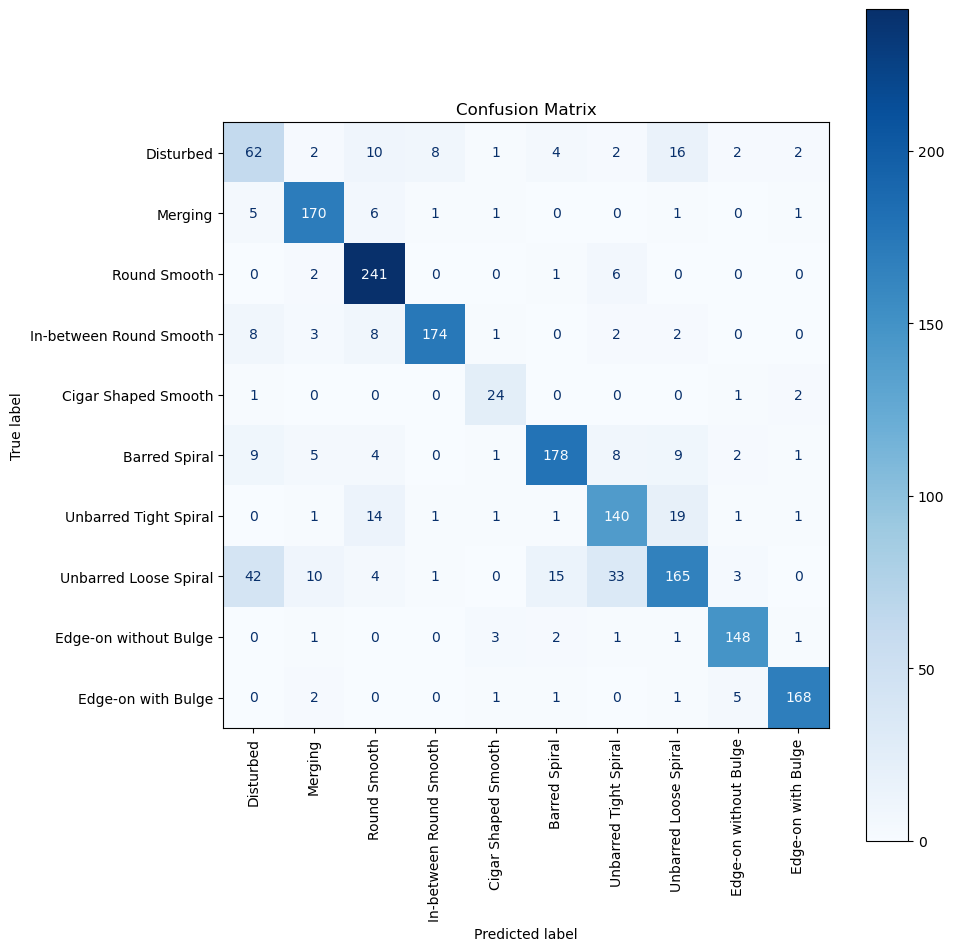


Final Test Performance:
Accuracy: 82.86%
Weighted F1: 82.74%


In [19]:
# Evaluation for 3rd try

import torch
import numpy as np
from datasets import load_dataset
from torchvision import transforms

weights = "/home/amorozov/DL/DL_HW_1_CV/wavemix_try3.pth"
IMG_SIZE = 256
BATCH_SIZE = 64

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

eval_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_ds = GalaxyDataset(galaxy_dataset['test'], eval_transform)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

model = WaveMix(
    num_classes=10,
    depth=16,
    mult=2,
    ff_channel=192,
    final_dim=192,
    dropout=0.3,
    level=3,
    initial_conv='pachify',
    patch_size=4
).to(device).float()

state_dict = torch.load(weights, map_location=device)
model.load_state_dict(state_dict)
model.eval()

test_preds = []
true_test_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device).float()
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)
        
        test_preds.extend(preds.cpu().numpy())
        true_test_labels.extend(labels.numpy())

preds_array = np.array(test_preds)
labels_array = np.array(true_test_labels)

metrics = evaluate_predictions(preds_array, labels_array, class_names)

print("\nFinal Test Performance:")
print(f"Accuracy: {metrics['accuracy']:.2%}")
print(f"Weighted F1: {metrics['f1_weighted']:.2%}")

In [ ]:
preds = # <Your preidctions here for TEST>
true_test_labels = galaxy_dataset['test']['label']
test_metrics = evaluate_predictions(preds, true_test_labels, class_names)